<img src="https://github.com/djp840/MSDS_453_Public/blob/main/images/NorthwesternHeader.png?raw=1">

## MSDS453 - Research Assignment 03 - Ontology Plus Context and Modeling

Take the ontology that you developed in week 6 and consider how your ten chosen documents for this quarter's class corpus map to that ontology.

Protégé is a tool that takes inputs for a human-created Ontology and creates a visualization.

Use Python algorithms to generate Knowledge Graphs from your documents.

TensorFlow Bidirectional RNN Model

In [1]:
import pandas as pd
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from collections import Counter
from dataclasses import dataclass
from timeit import default_timer as timer

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import gensim
from gensim.models import Word2Vec

import spacy
from spacy import displacy

from spacy.matcher import Matcher
from spacy.tokens import Span

import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

from IPython.display import display, HTML

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
tf.random.set_seed(2022)
import tensorflow.keras.backend as k

from typing import List, Callable, Dict, Tuple, Set

<div class="alert alert-block alert-danger">
<b>Required Installation: en_core_web_lg</b><br>"python -m spacy download en_core_web_lg"<br><br>English pipeline optimized for CPU. Components: tok2vec, tagger, parser, senter, ner, attribute_ruler, lemmatizer<br>
    <b>https://spacy.io/models/en#en_core_web_lg </b>
</div>

## Requires Restart Of Runtime After Installation

In [2]:
!python -m spacy download en_core_web_lg -q

2023-08-05 15:08:37.396772: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 1.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [3]:
nlp = spacy.load('en_core_web_lg')

### Mount Google Drive to Colab Environment

In [4]:
#from google.colab import drive
#drive.mount('/content/gdrive')

In [5]:
#! ls -l /content/gdrive

### NLTK Downloads

In [6]:
# Only run this once, they will be downloaded.
nltk.download('stopwords',quiet=True)
nltk.download('wordnet',quiet=True)
nltk.download('punkt',quiet=True)
nltk.download('omw-1.4',quiet=True)

True

<div class="alert alert-block alert-danger">
<b>Gensim</b> is a Python library for topic modelling, document indexing and similarity retrieval with large corpora. Target audience is the natural language processing (NLP) and information retrieval (IR) community <br><br>
    <b>https://pypi.org/project/gensim/ </b>
</div>

In [7]:
import pkg_resources
#pkg_resources.require("gensim<=3.8.3");

In [8]:
print("Genism Version: ", gensim.__version__)

Genism Version:  4.3.1


<div class="alert alert-block alert-info">
    <b>Suppress warning messages</b></div>

In [9]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## Data Wrangling Utility Functions

In [10]:
def add_movie_descriptor(data: pd.DataFrame, corpus_df: pd.DataFrame):
    """
    Adds "Movie Description" to the supplied dataframe, in the form {Genre}_{P|N}_{Movie Title}_{DocID}
    """
    review = np.where(corpus_df['Review Type (pos or neg)'] == 'Positive', 'P', 'N')
    data['Descriptor'] = corpus_df['Genre of Movie'] + '_' + corpus_df['Movie Title'] + '_' + review + '_' + corpus_df['Doc_ID'].astype(str)

def get_corpus_df(path: str) -> pd.DataFrame:
    data = pd.read_csv(path,encoding="utf-8")
    add_movie_descriptor(data, data)
    sorted_data = data.sort_values(['Descriptor'])
    indexed_data = sorted_data.set_index(['Doc_ID'])
    indexed_data['Doc_ID'] = indexed_data.index
    return indexed_data

def remove_punctuation(text: str) -> str:
    return re.sub('[^a-zA-Z]', '', str(text))

def remove_tags(text: str) -> str:
    return re.sub('&lt;/?.*?&gt;', '', text)

def remove_special_chars_and_digits(text: str) -> str:
    return re.sub('(\\d|\\W)+', '', text)

def get_sentences(text: str) -> List[str]:
    return [str(x) for x in nlp(text).sents]

def get_coref_resolved_sentences(text: str) -> List[str]:
    return [str(x) for x in nlp(text).sents]

def get_lemmas(text: str, stopwords: Set[str]) -> List[str]:
    initial = [remove_tags(remove_special_chars_and_digits(remove_punctuation(x.lemma_.lower()))) for x in nlp(text)]
    return [x for x in initial if x not in stopwords]

def lemmatize_sentence(text: str, stopwords: Set[str]) -> str:
    return ' '.join(get_lemmas(text, stopwords))

def clean_doc(doc):
    #doc = remove_punctuation(doc)
    doc= ' '.join(remove_stop_words(doc))
    doc = apply_lemmatization(doc)
    return doc

def remove_stop_words(in_text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(in_text)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    return filtered_sentence

def apply_lemmatization(in_text):
    # Lemmatization
    lem = WordNetLemmatizer()
    word_list = nltk.word_tokenize(in_text)
    output = ' '.join([lem.lemmatize(w) for w in word_list])
    return output

def counter_word(text):
  count=Counter()
  for i in text.values:
    for word in i.split():
      count[word]=+1
  return count

## Knowledge Context Graph Functions

In [11]:
def map_edges(map_to: str, map_from: Set[str], df: pd.DataFrame):
    print(f'Before mapping {", ".join(map_from)} -> {map_to}: {sum(df.edge == map_to)}')
    df['edge'] = np.where(kg_df.edge.isin(map_from), map_to, kg_df.edge)
    print(f'After mapping {", ".join(map_from)} -> {map_to}: {sum(df.edge == map_to)}')

def map_sources_and_targets(map_to: str, map_from: Set[str], df: pd.DataFrame):
    before = sum(df.source == map_to) + sum(df.target == map_to)
    print(f'Before mapping {", ".join(map_from)} -> {map_to}: {before}')

    df['source'] = np.where(kg_df.source.isin(map_from), map_to, kg_df.source)
    df['target'] = np.where(kg_df.target.isin(map_from), map_to, kg_df.target)

    after = sum(df.source == map_to) + sum(df.target == map_to)
    print(f'After mapping {", ".join(map_from)} -> {map_to}: {after}')

def get_neighborhood(sources: Set[str], edge_types: Set[str], depth: int, df: pd.DataFrame) -> pd.DataFrame:
    output = []

    for d in range(depth):
        if edge_types is not None:
            rows = df[(df.edge.isin(edge_types)) & ((df.source.isin(sources)) | (df.target.isin(sources)))].copy()
        else:
            rows = df[(df.source.isin(sources)) | (df.target.isin(sources))].copy()

        output.append(rows)
        sources = set(rows.target).union(set(rows.source))

    return pd.concat(output).drop_duplicates()

def find_sources_and_targets_with_patterns(patterns: List[str], df: pd.DataFrame):
    mask = np.zeros(kg_df.shape[0])
    for pattern in patterns:
        mask = mask | (df.source.str.contains(pattern)) | (df.target.str.contains(pattern))

    return df[mask]
# Examples of how to use the function:
# find_sources_and_targets_with_patterns(['action'], kg_df)
# find_sources_and_targets_with_patterns(['terror'], kg_df)
# find_sources_and_targets_with_patterns(['novel'], kg_df)
# find_sources_and_targets_with_patterns(['director', 'campbell'], kg_df)


def plot_graph(df: pd.DataFrame, show_edges: bool = False, figsize: Tuple[int, int] = (12, 12), use_circular: bool=True):
    graph = nx.from_pandas_edgelist(df, "source", "target", edge_attr='edge', create_using=nx.MultiDiGraph())

    plt.figure(figsize=figsize)
    if use_circular:
        pos = nx.circular_layout(graph)
    else:
        pos = nx.kamada_kawai_layout(graph)

    nx.draw(graph, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos=pos)
    if show_edges:
        nx.draw_networkx_edge_labels(graph, pos=pos, font_size=8)

    plt.show()

def get_top_sources_and_targets(df: pd.DataFrame, top: int = 10):
    return (Counter(df.source) + Counter(df.target)).most_common(top)

def get_top_edges(df: pd.DataFrame, top: int = 10):
    return Counter(df.edge).most_common(top)

#def get_dataset_partitions_pd(df, train_split=0.8, val_split=0.10, test_split=0.10):
#       # Specify seed to always have the same split distribution between runs
#    df_sample = df.sample(frac=1, random_state=12)
#    indices_or_sections = [int(.8*len(df)), int(.9*len(df))]
#    train_ds, val_ds, test_ds = np.split(df_sample, indices_or_sections)
#    return train_ds, val_ds, test_ds

# CHANGED

def get_dataset_partitions_pd(df, train_split=0.8, val_split=0.10, test_split=0.10):
    # Specify seed to always have the same split distribution between runs
    df_sample = df.sample(frac=1, random_state=12)
    # indices_or_sections = [int(.8*len(df)), int(.9*len(df))]
    indices_or_sections = [int(train_split * len(df)), int((train_split + val_split) * len(df))]
    train_ds, val_ds, test_ds = np.split(df_sample, indices_or_sections)

    # Removing 'Movie Title' from train and test datasets, keeping only in validation dataset
    train_ds = train_ds[['Text', 'Genre of Movie code']]
    test_ds = test_ds[['Text', 'Genre of Movie code']]

    return train_ds, val_ds, test_ds

## Entity Extraction Functions

In [12]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text

      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text

      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text

      ## chunk 5
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text

  return [ent1.strip(), ent2.strip()]

def get_relation(sent):
    try:
        doc = nlp(sent)

        # Matcher class object
        matcher = Matcher(nlp.vocab)

        #define the pattern
        pattern = [{'DEP':'ROOT'},
                {'DEP':'prep','OP':"?"},
                {'DEP':'agent','OP':"?"},
                {'POS':'ADJ','OP':"?"}]
        matcher.add("matching_1", [pattern])
        matches = matcher(doc)
        k = len(matches) - 1
        span = doc[matches[k][1]:matches[k][2]]

        return(span.text)
    except:
        pass

def get_subject_verb_object(sent):
  ent1 = ""
  ent2 = ""
  root = ""

  for tok in nlp(sent):
      if tok.dep_ == 'ROOT':
        root = tok.text
      elif tok.dep_ == "nsubj":
        ent1 = tok.text
      elif tok.dep_ == "dobj":
        ent2 = tok.text

      if ent1 != '' and ent2 != '' and root != '':
        break

  return [ent1, root, ent2]

## Visualization Utility Functions

In [13]:
def plot_confusion_matrix_labeled(y_true, y_pred, CLASSES_LIST):
    mtx = confusion_matrix(y_true, y_pred)
    # define classes
    classes = CLASSES_LIST
    temp_df = pd.DataFrame(data=mtx,columns=classes)
    temp_df.index = classes
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(temp_df, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

## Loading the Class Corpus

In [14]:
CORPUS_PATH=\
'https://raw.githubusercontent.com/barrycforever/MSDS_453_Public/main/MSDS453_ClassCorpus/MSDS453_QA_20220906.csv'
corpus_df = get_corpus_df(CORPUS_PATH)

## Exploratory Data Analysis

In [15]:
# Tokenize sentences
corpus_df['raw_sentences'] = corpus_df.Text.apply(get_sentences)
corpus_df.head(3).T

Doc_ID,40,41,42
DSI_Title,KCM_Doc1_AngelHasFallen,KCM_Doc2_AngelHasFallen,KCM_Doc3_AngelHasFallen
Text,Boredom sets in long before the start of Angel...,\nWho ARE all these people?\n\nThat was what...,Ric Roman Waughs Angel Has Fallen sees U.S. S...
Submission File Name,KCM_Doc1_AngelHasFallen,KCM_Doc2_AngelHasFallen,KCM_Doc3_AngelHasFallen
Student Name,KCM,KCM,KCM
Genre of Movie,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative
Movie Title,Angel Has Fallen,Angel Has Fallen,Angel Has Fallen
Descriptor,Action_Angel Has Fallen_N_40,Action_Angel Has Fallen_N_41,Action_Angel Has Fallen_N_42
Doc_ID,40,41,42
raw_sentences,[Boredom sets in long before the start of Ange...,"[\nWho, ARE all these people?\n\n, That was ...","[Ric Roman Waughs Angel Has, Fallen sees U.S...."


## Tokenize Words

In [16]:
default_stopwords=\
set(nltk.corpus.stopwords.words('english')).union(set(nlp.Defaults.stop_words)).union({' ', ''})
corpus_df['lemmas'] = corpus_df.Text.apply(lambda x: get_lemmas(x, default_stopwords))
corpus_df.lemmas.head()

Doc_ID
40    [boredom, set, long, start, angel, fall, start...
41    [people, mutter, enter, screening, angel, fall...
42    [ric, roman, waughs, angel, fallen, secret, se...
43    [certain, mindless, pleasure, fallen, movie, w...
44    [dont, need, olympus, fallen, andor, london, f...
Name: lemmas, dtype: object

In [17]:
corpus_df.head(3).T

Doc_ID,40,41,42
DSI_Title,KCM_Doc1_AngelHasFallen,KCM_Doc2_AngelHasFallen,KCM_Doc3_AngelHasFallen
Text,Boredom sets in long before the start of Angel...,\nWho ARE all these people?\n\nThat was what...,Ric Roman Waughs Angel Has Fallen sees U.S. S...
Submission File Name,KCM_Doc1_AngelHasFallen,KCM_Doc2_AngelHasFallen,KCM_Doc3_AngelHasFallen
Student Name,KCM,KCM,KCM
Genre of Movie,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative
Movie Title,Angel Has Fallen,Angel Has Fallen,Angel Has Fallen
Descriptor,Action_Angel Has Fallen_N_40,Action_Angel Has Fallen_N_41,Action_Angel Has Fallen_N_42
Doc_ID,40,41,42
raw_sentences,[Boredom sets in long before the start of Ange...,"[\nWho, ARE all these people?\n\n, That was ...","[Ric Roman Waughs Angel Has, Fallen sees U.S...."


## Reassemble Leminized Words

In [18]:
corpus_df['lemmas_joined'] = corpus_df.lemmas.apply(lambda x: ' '.join(x))

In [19]:
corpus_df['lemmas_joined'].head()

Doc_ID
40    boredom set long start angel fall start journe...
41    people mutter enter screening angel fallen loc...
42    ric roman waughs angel fallen secret service a...
43    certain mindless pleasure fallen movie watch g...
44    dont need olympus fallen andor london fallen u...
Name: lemmas_joined, dtype: object

In [20]:
corpus_df.head(3).T

Doc_ID,40,41,42
DSI_Title,KCM_Doc1_AngelHasFallen,KCM_Doc2_AngelHasFallen,KCM_Doc3_AngelHasFallen
Text,Boredom sets in long before the start of Angel...,\nWho ARE all these people?\n\nThat was what...,Ric Roman Waughs Angel Has Fallen sees U.S. S...
Submission File Name,KCM_Doc1_AngelHasFallen,KCM_Doc2_AngelHasFallen,KCM_Doc3_AngelHasFallen
Student Name,KCM,KCM,KCM
Genre of Movie,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative
Movie Title,Angel Has Fallen,Angel Has Fallen,Angel Has Fallen
Descriptor,Action_Angel Has Fallen_N_40,Action_Angel Has Fallen_N_41,Action_Angel Has Fallen_N_42
Doc_ID,40,41,42
raw_sentences,[Boredom sets in long before the start of Ange...,"[\nWho, ARE all these people?\n\n, That was ...","[Ric Roman Waughs Angel Has, Fallen sees U.S...."


## Vocabulary Data Wrangling

In [21]:
vectorizer = CountVectorizer(ngram_range=(1, 1))
transformed_documents = vectorizer.fit_transform(corpus_df.lemmas_joined)
doc_term_matrix = transformed_documents.todense()
doc_term_df = pd.DataFrame(doc_term_matrix,
                           columns=vectorizer.get_feature_names_out(),
                           index=corpus_df.Descriptor)
print(f'All Word Vocabulary size: {doc_term_df.shape[1]}')
all_words = set(doc_term_df.columns)

vectorizer = CountVectorizer(ngram_range=(1, 1), min_df=5, max_df=.8)
transformed_documents = vectorizer.fit_transform(corpus_df.lemmas_joined)
doc_term_matrix = transformed_documents.todense()
doc_term_df = pd.DataFrame(doc_term_matrix,
                           columns=vectorizer.get_feature_names_out(),
                           index=corpus_df.Descriptor)
print(f'Curated Vocabulary size: {doc_term_df.shape[1]}')
vocabulary = set(doc_term_df.columns)

words_to_remove = default_stopwords.union(all_words - vocabulary)

All Word Vocabulary size: 12221
Curated Vocabulary size: 2907


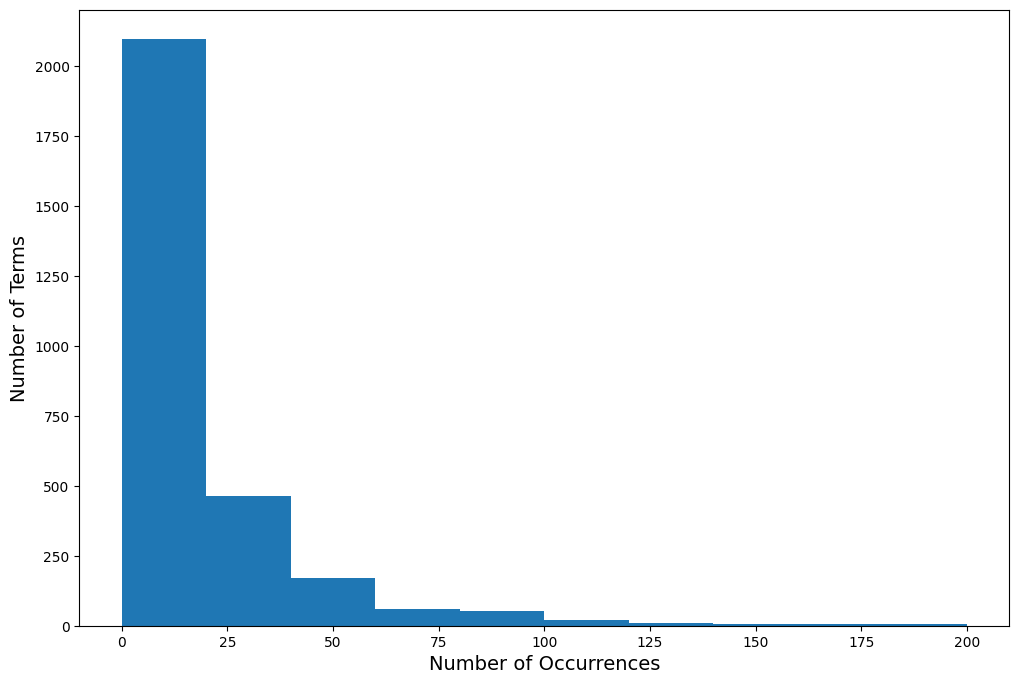

In [22]:
plt.figure(figsize = (12, 8))
plt.hist(doc_term_df.sum(axis=0).T, range=(0, 200))
plt.xlabel('Number of Occurrences',fontsize=14)
plt.ylabel('Number of Terms',fontsize=14);

In [23]:
# Re-tokenize words, recreate joined documents
corpus_df['lemmas'] = corpus_df.Text.apply(lambda x: get_lemmas(x, words_to_remove))
corpus_df['lemmas_joined'] = corpus_df.lemmas.apply(lambda x: ' '.join(x))
corpus_df.lemmas.head()

Doc_ID
40    [set, long, start, angel, fall, start, journey...
41    [people, enter, angel, fallen, local, cinema, ...
42    [ric, roman, angel, fallen, secret, service, a...
43    [certain, pleasure, fallen, watch, gerard, but...
44    [dont, need, olympus, fallen, andor, london, f...
Name: lemmas, dtype: object

## Get Lemmatized and Filtered Sentences

Removes the additional words

In [24]:
corpus_df['sentences_lemmatized']=\
corpus_df.raw_sentences.apply(lambda x: [lemmatize_sentence(s, words_to_remove) for s in x])

In [25]:
corpus_df.head().T

Doc_ID,40,41,42,43,44
DSI_Title,KCM_Doc1_AngelHasFallen,KCM_Doc2_AngelHasFallen,KCM_Doc3_AngelHasFallen,KCM_Doc4_AngelHasFallen,KCM_Doc5_AngelHasFallen
Text,Boredom sets in long before the start of Angel...,\nWho ARE all these people?\n\nThat was what...,Ric Roman Waughs Angel Has Fallen sees U.S. S...,There is a certain mindless pleasure in the Fa...,"No, you dont need to have seen Olympus Has F..."
Submission File Name,KCM_Doc1_AngelHasFallen,KCM_Doc2_AngelHasFallen,KCM_Doc3_AngelHasFallen,KCM_Doc4_AngelHasFallen,KCM_Doc5_AngelHasFallen
Student Name,KCM,KCM,KCM,KCM,KCM
Genre of Movie,Action,Action,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative,Negative,Negative
Movie Title,Angel Has Fallen,Angel Has Fallen,Angel Has Fallen,Angel Has Fallen,Angel Has Fallen
Descriptor,Action_Angel Has Fallen_N_40,Action_Angel Has Fallen_N_41,Action_Angel Has Fallen_N_42,Action_Angel Has Fallen_N_43,Action_Angel Has Fallen_N_44
Doc_ID,40,41,42,43,44
raw_sentences,[Boredom sets in long before the start of Ange...,"[\nWho, ARE all these people?\n\n, That was ...","[Ric Roman Waughs Angel Has, Fallen sees U.S....",[There is a certain mindless pleasure in the F...,"[No, you dont need to have seen Olympus Has ..."


## Review Documents By Movie Title

In [26]:
print(corpus_df['Movie Title'].unique())

['Angel Has Fallen' 'Inception' 'No Time To Die' 'Taken' 'Taxi'
 'Despicable Me 3' 'Dirty Grandpa' 'Holmes and Watson' 'Legally Blonde'
 'The Lost City' 'Drag me to hell' 'Fresh' 'It Chapter Two'
 'The Toxic Avenger' 'US' 'Batman' 'Equilibrium' 'Minority Report'
 'Oblivion' 'Pitch Black']


In [27]:
movie_df = corpus_df[corpus_df['Movie Title'] == 'Dirty Grandpa'].copy()
movie_df.head(3).T

Doc_ID,35,36,37
DSI_Title,PYC_Doc6_DirtyGrandpa,PYC_Doc7_DirtyGrandpa,PYC_Doc8_DirtyGrandpa
Text,"Make no mistake about it, Robert De Niro is a ...",This is a very disturbing and difficult movie ...,"On Jan. 22, “Dirty Grandpa” was unleashed on t..."
Submission File Name,PYC_Doc6_DirtyGrandpa,PYC_Doc7_DirtyGrandpa,PYC_Doc8_DirtyGrandpa
Student Name,PYC,PYC,PYC
Genre of Movie,Comedy,Comedy,Comedy
Review Type (pos or neg),Negative,Negative,Negative
Movie Title,Dirty Grandpa,Dirty Grandpa,Dirty Grandpa
Descriptor,Comedy_Dirty Grandpa_N_35,Comedy_Dirty Grandpa_N_36,Comedy_Dirty Grandpa_N_37
Doc_ID,35,36,37
raw_sentences,"[Make no mistake about it, Robert De Niro is a...",[This is a very disturbing and difficult movie...,"[On Jan. 22, “Dirty Grandpa” was unleashed on ..."


## Knowledge Graph Extraction

In [28]:
corpus_text_sentences = [y for x in movie_df.raw_sentences for y in x]
example_sentence = nlp(corpus_text_sentences[5])
corpus_text_sentences[5]

'The film’s plot (what there is of it) centers on\xa0an uptight young lawyer, Jason (Efron), who is about to be married to a wedding-obsessed fiancee (a one-note Julianne Hough).'

In [ ]:
entity_pairs = [get_entities(x) for x in tqdm(corpus_text_sentences)]

In [ ]:
entity_pairs

### Create DataFrame (Source, Target, Edge)

In [ ]:
relations = [get_relation(x) for x in corpus_text_sentences]
#extract subject and object
source = [i[0] for i in entity_pairs]
target = [i[1] for i in entity_pairs]
kg_df = pd.DataFrame({'source': source, 'target': target, 'edge': relations})

### Knowledge Graph Preprocessing (Lowercase, Remove Empty Spaces)

In [ ]:
# Move everything to lower case
kg_df.source = kg_df.source.str.lower()
kg_df.target = kg_df.target.str.lower()
kg_df.edge = kg_df.edge.str.lower()

# Filter out empties
kg_df = kg_df[kg_df.source != '']
kg_df = kg_df[kg_df.target != '']
kg_df = kg_df[kg_df.edge != ''].copy()

In [ ]:
kg_df.head(6).T

In [ ]:
kg_df.shape

In [ ]:
len(corpus_text_sentences)

In [ ]:
plot_graph(kg_df, use_circular=True)

## Recurrent Neural Network (RNN) Model Development

<img src="https://github.com/djp840/MSDS_453_Public/blob/main/images/BidirectionalRNN.png?raw=true">

<div class="alert alert-block alert-info">
    <b>tf.keras.layers.Bidirectional</b><br>
    https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional
    </div>

In [29]:
datafull=corpus_df.copy()
datafull.reset_index(drop=True, inplace=True)
datafull.head(4).T

,0,1,2,3
DSI_Title,KCM_Doc1_AngelHasFallen,KCM_Doc2_AngelHasFallen,KCM_Doc3_AngelHasFallen,KCM_Doc4_AngelHasFallen
Text,Boredom sets in long before the start of Angel...,\nWho ARE all these people?\n\nThat was what...,Ric Roman Waughs Angel Has Fallen sees U.S. S...,There is a certain mindless pleasure in the Fa...
Submission File Name,KCM_Doc1_AngelHasFallen,KCM_Doc2_AngelHasFallen,KCM_Doc3_AngelHasFallen,KCM_Doc4_AngelHasFallen
Student Name,KCM,KCM,KCM,KCM
Genre of Movie,Action,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative,Negative
Movie Title,Angel Has Fallen,Angel Has Fallen,Angel Has Fallen,Angel Has Fallen
Descriptor,Action_Angel Has Fallen_N_40,Action_Angel Has Fallen_N_41,Action_Angel Has Fallen_N_42,Action_Angel Has Fallen_N_43
Doc_ID,40,41,42,43
raw_sentences,[Boredom sets in long before the start of Ange...,"[\nWho, ARE all these people?\n\n, That was ...","[Ric Roman Waughs Angel Has, Fallen sees U.S....",[There is a certain mindless pleasure in the F...


In [30]:
datafull['Text'] = datafull['Text'].apply(lambda x :clean_doc(x))

## Preprocess DataSet

In [31]:
#data = datafull[['Text','Genre of Movie']].copy()

data = datafull[['Movie Title', 'Text','Genre of Movie']].copy() # CHANGED

In [32]:
data['Genre of Movie'] = data['Genre of Movie'].astype("category")
data['Genre of Movie code'] = data['Genre of Movie'].cat.codes
data['Genre of Movie code'].tail().T

195    3
196    3
197    3
198    3
199    3
Name: Genre of Movie code, dtype: int8

## Review Examples by Genre

In [33]:
features, targets = data['Text'], data['Genre of Movie code']
data[["Genre of Movie","Genre of Movie code"]].value_counts()

Genre of Movie  Genre of Movie code
Action          0                      50
Comedy          1                      50
Horror          2                      50
Sci-Fi          3                      50
dtype: int64

## Create Datasets for Model Development

### Cell 10 - def get_dataset_partitions_pd

In [34]:
#trainds, valds, testds = get_dataset_partitions_pd(data[['Text','Genre of Movie code']])

#CHANGED
trainds, valds, testds = get_dataset_partitions_pd(data[['Movie Title', 'Text', 'Genre of Movie code']])

trainds.shape, valds.shape, testds.shape

((160, 2), (20, 3), (20, 2))

## Convert DataFrame to TensorFlow DataSet

In [35]:
# train X & y
#train_text_ds_raw = tf.data.Dataset.from_tensor_slices(
#            tf.cast(trainds['Text'].values, tf.string)
#)
train_text_ds_raw = tf.data.Dataset.from_tensor_slices(trainds['Text'].values) # CHANGED

#train_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
#            tf.cast(trainds['Genre of Movie code'].values, tf.int64),
#  )
# test X & y
train_cat_ds_raw = tf.data.Dataset.from_tensor_slices(trainds['Genre of Movie code'].values) # CHANGED

test_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(testds['Text'].values, tf.string)
)
test_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(testds['Genre of Movie code'].values, tf.int64),
)
#val X & Y

val_ds_raw = tf.data.Dataset.from_tensor_slices((valds['Movie Title'].values, valds['Text'].values, valds['Genre of Movie code'].values)) # CHANGE
val_movie_titles_ds = val_ds_raw.map(lambda title, text, label: title) # CHANGED

#val_text_ds_raw = tf.data.Dataset.from_tensor_slices(
#            tf.cast(valds['Text'].values, tf.string)
#)
val_text_ds_raw = val_ds_raw.map(lambda title, text, label: text) # CHANGED

#val_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
#            tf.cast(valds['Genre of Movie code'].values, tf.int64),
#)
val_cat_ds_raw = val_ds_raw.map(lambda title, text, label: label) # CHANGED


## Create DataSets (X=Preprocessed Text, Y=Encoded Categories)

In [36]:
train_ds = tf.data.Dataset.zip(
    (
            train_text_ds_raw,
            train_cat_ds_raw
     )
)
test_ds = tf.data.Dataset.zip(
    (
            test_text_ds_raw,
            test_cat_ds_raw
     )
)
val_ds = tf.data.Dataset.zip(
    (
            val_text_ds_raw,
            val_cat_ds_raw
     )
)

## Create Data Pipelines (Batching, Shuffling, and Optimizing)

In [37]:
batch_size = 3
AUTOTUNE = tf.data.experimental.AUTOTUNE
buffer_size=train_ds.cardinality().numpy()

train_ds = train_ds.shuffle(buffer_size=buffer_size)\
                   .batch(batch_size=batch_size,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)

test_ds = test_ds.shuffle(buffer_size=buffer_size)\
                   .batch(batch_size=batch_size,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)


val_ds = val_ds.shuffle(buffer_size=buffer_size)\
                   .batch(batch_size=batch_size,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Movie Title          200 non-null    object  
 1   Text                 200 non-null    object  
 2   Genre of Movie       200 non-null    category
 3   Genre of Movie code  200 non-null    int8    
dtypes: category(1), int8(1), object(2)
memory usage: 3.8+ KB


## Create the Text Encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `experimental.preprocessing.TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:
The processing of each sample contains the following steps:

    standardize each sample (usually lowercasing + punctuation stripping)
    split each sample into substrings (usually words)
    recombine substrings into tokens (usually ngrams)
    index tokens (associate a unique int value with each token)
    transform each sample using this index, either into a vector of ints or a dense float vector.

<div class="alert alert-block alert-info">
    <b>tf.keras.layers.TextVectorization</b><br>
   https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization
    </div>

In [39]:
VOCAB_SIZE=5000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE, standardize="lower_and_strip_punctuation", pad_to_max_tokens= True)
encoder.adapt(train_ds.map(lambda text, label: text), batch_size= None)

In [40]:
vocab = np.array(encoder.get_vocabulary())
len(vocab)

5000

In [41]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 's', 'the', 'film', '’', 'i', 'movie', 'one', 'like',
       'time', 'it', 'make', 'nt', 'get', 'character', 'even', 'but', '”',
       '“'], dtype='<U19')

In [42]:
vocab[-20:]

array(['underplays', 'underlined', 'underdeveloped', 'undercurrent',
       'undeniable', 'uncover', 'unconventional', 'unconscious',
       'uncomfortably', 'uncle', 'unbeknownst', 'unashamedly',
       'unapologetic', 'unanswered', 'unabomber', 'unabashedly',
       'twilight', 'twang', 'tutu', 'turf'], dtype='<U19')

In [43]:
# CHANGED

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import tensorflow as tf

max_features = 10000  # Maximum vocab size.
sequence_length = 500  # Sequence length to pad the outputs to.

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return stripped_html

# New TextVectorization layer
text_vectorizer_with_titles = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)


In [44]:
# CHANGED

# Adapt the text vectorization layer to the training text data
text_vectorizer_with_titles.adapt(train_text_ds_raw)


## Example of Encoded Words

In [45]:
encoded_example = encoder('encanto we dont talk about bruno no no').numpy()
encoded_example[:]

array([   1,  174,    1,  830, 2998,    1,  128,  128])

In [46]:
len(encoder.get_vocabulary())

5000

In [47]:
encoder(data['Text'][0])

<tf.Tensor: shape=(507,), dtype=int64, numpy=
array([   1,   54,   81,  112,  434,  225,  323,    6,  112, 2052,    7,
       2937,   43, 2493,   60, 2134,  215,   60,  656,    9, 2103, 2630,
       4683,    1,  218,    1,    1, 3201,    1,    6,  665,    1, 3069,
        376, 1594,    1,  634,    6,   71,   60,  835, 3789,    9,   66,
         24,    7,    1,    1, 4408,  119,   71, 1325,  119,  213,  119,
          1,   11,  597,    8,  456, 1037, 3281,  104,    1,   93, 4021,
       1667,   91,   41, 1188,  237,  434,  225,  323,  625,  532,   35,
         41, 1188,   29,  339,    7,   82, 1193,  615,   41, 1339,  262,
         84, 2470,   29, 1253,  464,  403,    1,  281,  363,   35,  283,
       1667, 1537,  160,  597,  581, 2493, 2523,  104,   56,  191,  581,
        810,  725,   88, 3001, 3251,  370,  969,   64,  466,  886, 1352,
       3329,    1,  273,  491,  283,  213,    6,    1, 1352,    1, 4622,
         34,   40, 2406,    1, 1118, 3948,  327, 1161, 2129, 1892,    6,
     

In [48]:
for example, label in train_ds.take(1):
  print('texts: ', example.numpy()[:1])
  print()

texts:  [b'My hope high \xe2\x80\x9c Dirty Grandpa , \xe2\x80\x9d simply mere existence made practical sense . A movie starring Robert De Niro Zac Efron \xe2\x80\x99 sound like real movie . It sound like fake movie \xe2\x80\x99 see clip film \xe2\x80\x99 mocking stupidity Hollywood . For intent purpose , \xe2\x80\x9c Dirty Grandpa \xe2\x80\x9d exist form one fake trailer open \xe2\x80\x9c Tropic Thunder . \xe2\x80\x9d And yet , . All 102 minute . Before watching , mind raced stupid possibility . How many Viagra joke would ? Would somebody ask De Niro Viagra induced boner De Niro respond , \xe2\x80\x9c Are talking ? \xe2\x80\x9d shortly one grip run onto set give high five ? Would scene dog win farting contest fart hard launch inside bare , gaping as competitor : cameo Harvey Keitel ( , \xe2\x80\x99 implied , accidentally overdosed Viagra ) ? Unfortunately , moment \xe2\x80\x93 outside Pinterest page and/or dream board . But luckily , got equally stupid . Maybe even little . As may alre

## Build RNN Sequential Model

<div class="alert alert-block alert-info">
    <b>tf.keras.layers</b><br>
    https://www.tensorflow.org/api_docs/python/tf/keras/layers
    </div>

In [49]:
k.clear_session()
num_classes=4
model=tf.keras.Sequential([encoder
   ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
   ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True, dropout=0.3))
   ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,dropout=0.3))
   ,tf.keras.layers.Dense(64, activation='relu')
   ,tf.keras.layers.Dense(num_classes,activation='softmax')
])

In [50]:
# CHANGED
# Update the model's text input preprocessing layer
model.layers[0].adapt(text_vectorizer_with_titles.get_vocabulary())

In [51]:
model.compile(optimizer= tf.keras.optimizers.Adam( )
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy()
              ,metrics=['accuracy'])

In [52]:
# CHANGED
# New validation dataset that includes the movie titles
val_ds_with_titles = tf.data.Dataset.zip((val_text_ds_raw, val_cat_ds_raw))
val_ds_with_titles = val_ds_with_titles.batch(batch_size=batch_size, drop_remainder=True).cache().prefetch(AUTOTUNE)

# Fit the model again using the new validation dataset
%time
history = model.fit(
    train_ds,
    epochs=200,
    validation_data=val_ds_with_titles,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)],
)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs
Epoch 1/200
53/53 [==============================] - 105s 2s/step - loss: 1.3936 - accuracy: 0.2264 - val_loss: 1.3976 - val_accuracy: 0.2222
Epoch 2/200
53/53 [==============================] - 78s 1s/step - loss: 1.3851 - accuracy: 0.2453 - val_loss: 1.4134 - val_accuracy: 0.1667
Epoch 3/200
53/53 [==============================] - 77s 1s/step - loss: 1.3506 - accuracy: 0.3208 - val_loss: 1.3464 - val_accuracy: 0.5000
Epoch 4/200
53/53 [==============================] - 77s 1s/step - loss: 0.9920 - accuracy: 0.6478 - val_loss: 1.6966 - val_accuracy: 0.3333
Epoch 5/200
53/53 [==============================] - 77s 1s/step - loss: 0.5150 - accuracy: 0.8742 - val_loss: 1.5340 - val_accuracy: 0.2778


In [53]:
# CHANGED
val_movie_titles = [title.decode('utf-8') for title in val_movie_titles_ds.as_numpy_iterator()]
val_movie_titles

['Despicable Me 3',
 'No Time To Die',
 'Holmes and Watson',
 'No Time To Die',
 'Fresh',
 'Equilibrium',
 'Minority Report',
 'Holmes and Watson',
 'Drag me to hell',
 'It Chapter Two',
 'Pitch Black',
 'US',
 'The Lost City',
 'Fresh',
 'Batman',
 'Equilibrium',
 'Equilibrium',
 'Drag me to hell',
 'Taken',
 'Legally Blonde']

In [54]:
# CHANGED
# Create a dataset with only the validation texts
val_text_ds = val_text_ds_raw.batch(batch_size=batch_size)

# Predict the labels for the validation texts
val_predictions = model.predict(val_text_ds)
val_predicted_labels = np.argmax(val_predictions, axis=-1)  # Take the index of the max value to get the predicted label

# Extract the true labels from val_cat_ds_raw
val_true_labels = [label for label in val_cat_ds_raw.as_numpy_iterator()]

# Now val_predicted_labels contains the predicted labels and val_true_labels contains the true labels.


7/7 [==============================] - 7s 173ms/step


In [55]:
# CHANGED
import pandas as pd

results_df = pd.DataFrame({
    "Movie Title": val_movie_titles,
    "True Label": val_true_labels,
    "Predicted Label": val_predicted_labels
})

# Display the DataFrame
print(results_df)


          Movie Title  True Label  Predicted Label
0     Despicable Me 3           1                0
1      No Time To Die           0                1
2   Holmes and Watson           1                1
3      No Time To Die           0                1
4               Fresh           2                1
5         Equilibrium           3                2
6     Minority Report           3                3
7   Holmes and Watson           1                2
8     Drag me to hell           2                3
9      It Chapter Two           2                0
10        Pitch Black           3                3
11                 US           2                2
12      The Lost City           1                0
13              Fresh           2                0
14             Batman           3                3
15        Equilibrium           3                1
16        Equilibrium           3                0
17    Drag me to hell           2                1
18              Taken          

In [56]:
val_loss, val_accuracy = model.evaluate(val_ds)
print('Validation Loss: ', val_loss)
print('Validation Accuracy: ', val_accuracy)


6/6 [==============================] - 1s 179ms/step - loss: 1.5770 - accuracy: 0.2778
Validation Loss:  1.5769624710083008
Validation Accuracy:  0.2777777910232544


## Model Performance Test Accuracy

In [58]:
test_loss, test_acc = model.evaluate(test_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

6/6 [==============================] - 7s 164ms/step - loss: 1.0061 - accuracy: 0.5000
Test Loss: 1.0061147212982178
Test Accuracy: 0.5


## Plotting Performance Metrics - Multi-Layer Bidirectional RNN

In [59]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [60]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
0,1.394,0.226,1.398,0.222
1,1.385,0.245,1.413,0.167
2,1.351,0.321,1.346,0.500
3,0.992,0.648,1.697,0.333
4,0.515,0.874,1.534,0.278


In [61]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

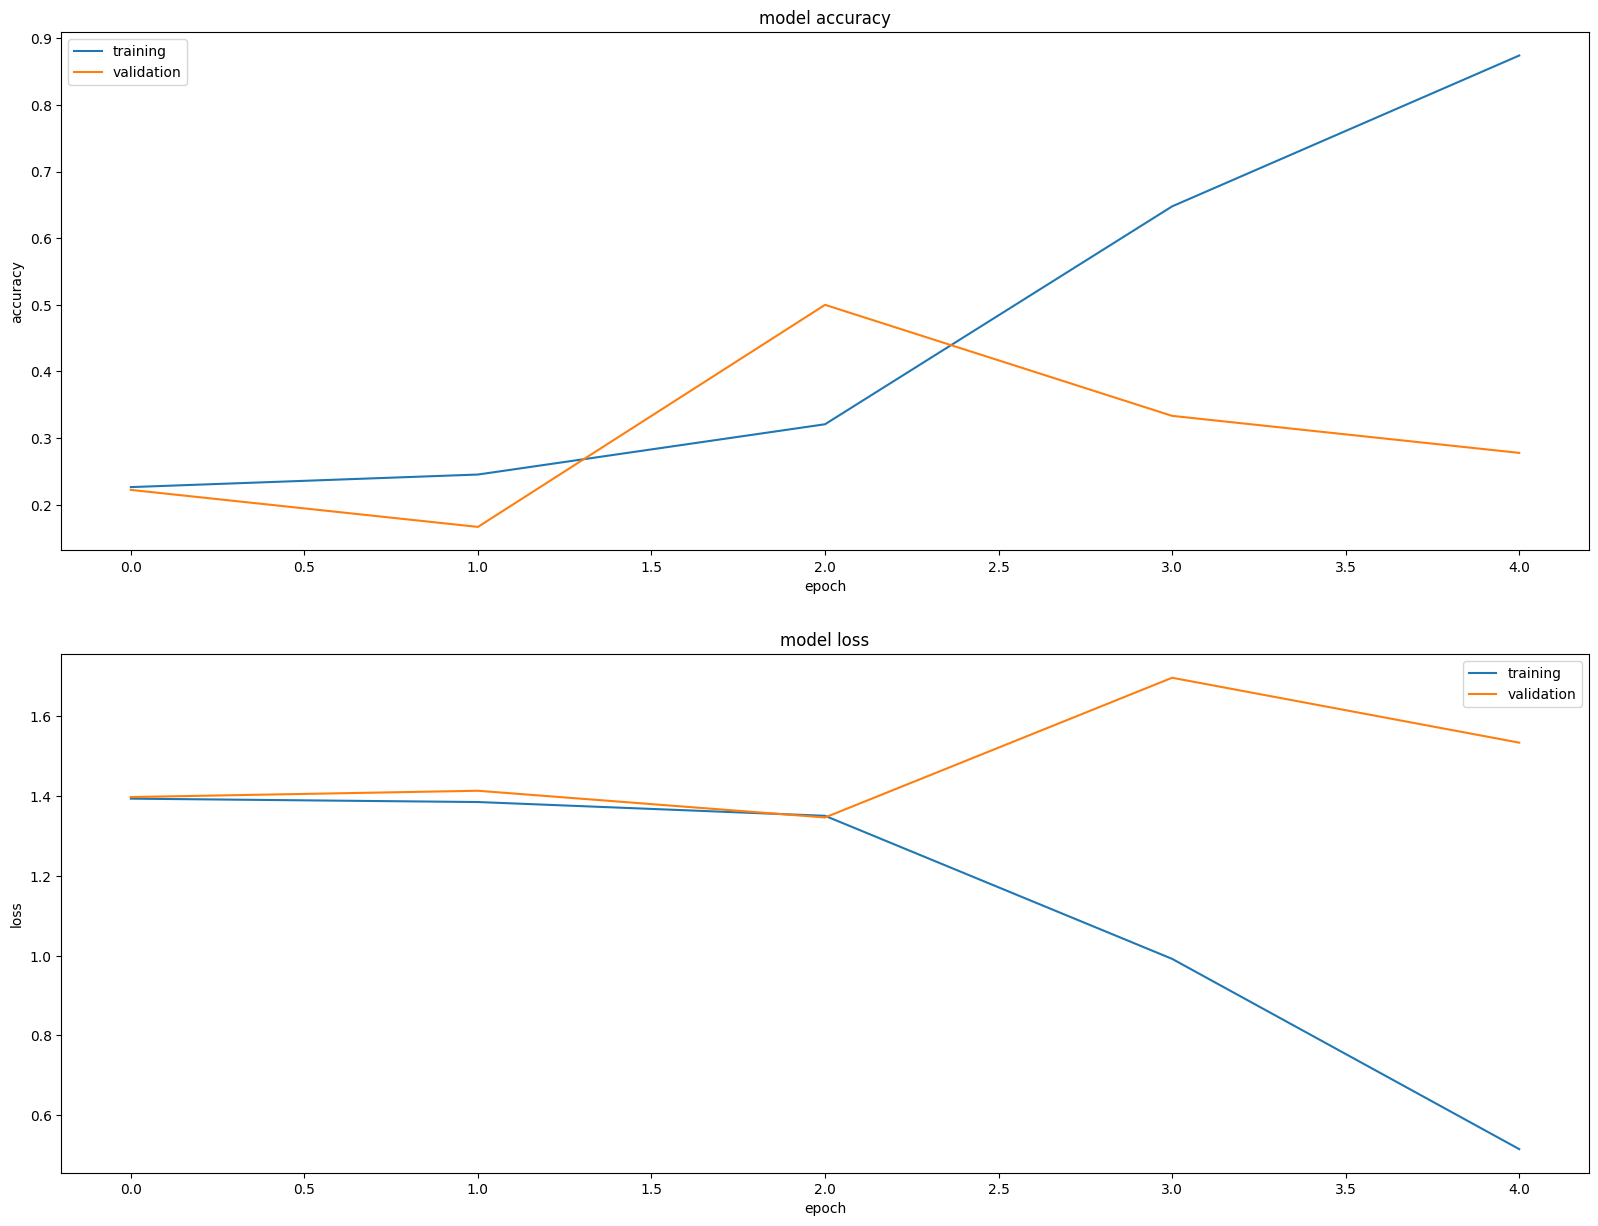

In [62]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

## Confusion Matrix Post Model Performance Analysis

In [63]:
preds2 = model.predict(test_ds)
y_pred2 = np.argmax(preds2, axis=1)
y2 = np.concatenate([y for x, y in test_ds], axis=0)

6/6 [==============================] - 7s 169ms/step


In [64]:
CLASSES_LIST = ['Action','Comedy','Horror','Sci Fi']

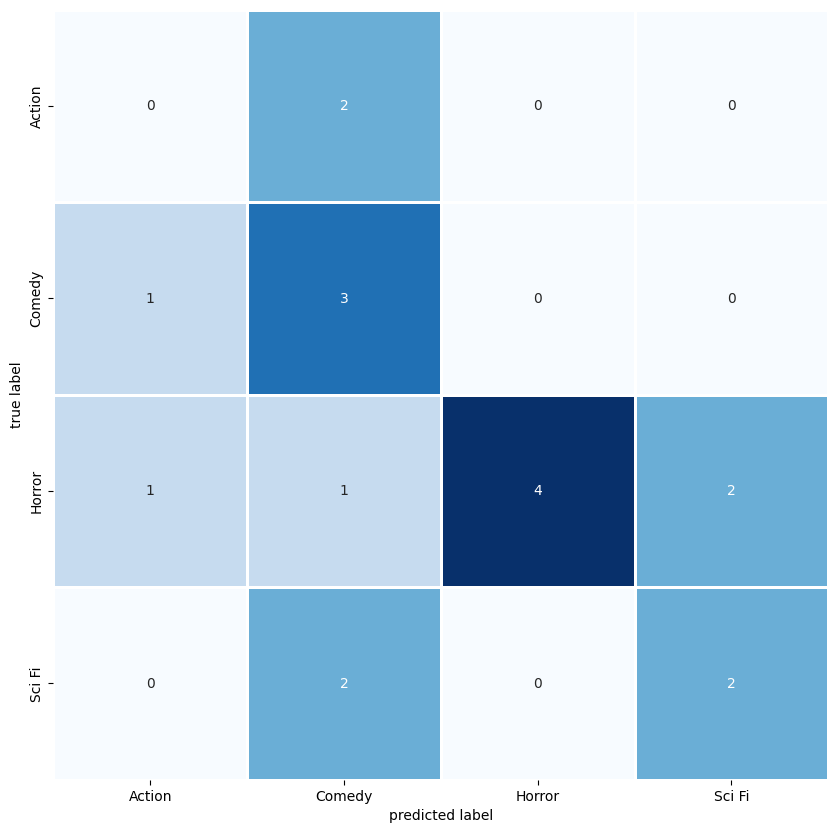

In [65]:
plot_confusion_matrix_labeled(y2,y_pred2, CLASSES_LIST=CLASSES_LIST)

In [66]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [67]:
df2 = pd.DataFrame(preds2[0:15]
                  ,columns = CLASSES_LIST).T
df2.style.format("{:.2%}").background_gradient(cmap=cm)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Action,39.46%,11.79%,3.98%,26.76%,6.29%,26.56%,77.16%,22.35%,15.11%,20.85%,6.70%,73.77%,44.19%,9.20%,12.24%
Comedy,41.70%,41.03%,6.50%,36.97%,28.33%,5.50%,7.10%,3.61%,15.59%,66.34%,1.55%,8.27%,49.74%,48.08%,73.26%
Horror,10.86%,9.96%,27.78%,15.38%,5.24%,63.37%,14.50%,71.85%,30.85%,3.11%,90.19%,16.38%,2.04%,6.22%,3.62%
Sci Fi,7.98%,37.23%,61.74%,20.90%,60.14%,4.57%,1.24%,2.19%,38.44%,9.70%,1.56%,1.58%,4.03%,36.50%,10.88%


## RNN Model Architecture

In [68]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          320000    
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                        